In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import asc, col, isnan, when, count, median, udf, concat, month, year, substring, lit, desc
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import os
import pyarrow
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Create a pyspark session and read the data
conf = SparkConf() \
    .setAppName("data_ana") \
    .set("spark.driver.memory", "12g")\
    .set("spark.executor.cores","8") \
    .set("spark.sql.execution.arrow.pyspark.enabled","true")

spark = SparkSession.builder.config(conf=conf).getOrCreate()

csv_file_path ="/workspace/data.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/24 08:36:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Chuyển đổi kiểu dữ liệu sang số nguyên (IntegerType) trong PySpark

Đoạn mã PySpark này thực hiện chuyển đổi kiểu dữ liệu của ba cột trong DataFrame (`df`) sang kiểu số nguyên (`IntegerType`).  Điều này đảm bảo rằng các cột này được lưu trữ và xử lý dưới dạng số nguyên, phù hợp cho các phép toán số học và phân tích.

In [3]:
#Cast column to integer type
df = df.withColumn("ncodpers", df["ncodpers"].cast(IntegerType()))
df = df.withColumn("ind_nomina_ult1", df["ind_nomina_ult1"].cast(IntegerType()))
df = df.withColumn("ind_nom_pens_ult1", df["ind_nom_pens_ult1"].cast(IntegerType()))

## Thống Kê Số Lượng Khách Hàng Mới Sử Dụng Sản Phẩm (Product Adoption) Theo Tháng

Đoạn mã này sử dụng Spark để phân tích và thống kê số lượng khách hàng mới bắt đầu sử dụng một sản phẩm cụ thể (product adoption) theo từng tháng. Nó tập trung vào việc xác định các khách hàng đã chuyển từ không sử dụng sản phẩm (giá trị 0) sang sử dụng sản phẩm (giá trị 1) trong khoảng thời gian 1 tháng.

**Các Bước:**

1.  **Chuẩn Bị Dữ Liệu:**
    *   Chuyển đổi cột `fecha_dato` sang kiểu ngày.
    *   Xác định danh sách các cột đại diện cho sản phẩm (`target_cols`).
    *   Tạo cửa sổ `w` để phân vùng dữ liệu theo khách hàng (`ncodpers`) và sắp xếp theo ngày (`fecha_dato`).

2.  **Tính Giá Trị Lag:**
    *   Sử dụng cửa sổ `w` để tạo cột `prev_fecha` chứa ngày tháng của tháng trước.
    *   Với mỗi sản phẩm, tạo một cột mới có tên `prev_{col}` chứa giá trị của sản phẩm đó trong tháng trước.

3.  **Xác Định Khách Hàng Mới Sử Dụng Sản Phẩm:**
    *   Với mỗi sản phẩm, tạo một cột mới có tên `{col}_new`. Cột này nhận giá trị 1 nếu khách hàng:
        *   Không sử dụng sản phẩm trong tháng trước (`F.col(f"prev_{col}") == 0`).
        *   Sử dụng sản phẩm trong tháng hiện tại (`F.col(col) == 1`).
        *   Sự thay đổi này xảy ra trong vòng 1 tháng (`F.datediff(F.col("fecha_dato"), F.col("prev_fecha")) < 32`).

4.  **Tổng Hợp Số Lượng Khách Hàng Mới Sử Dụng Sản Phẩm Theo Tháng:**
    *   Nhóm dữ liệu theo `fecha_dato` (ngày tháng, đại diện cho tháng).
    *   Với mỗi sản phẩm, tính tổng số các khách hàng mới sử dụng sản phẩm đó trong tháng đó (sử dụng `F.sum(f"{col}_new")`).
    *   Sắp xếp kết quả theo ngày tháng (`orderBy("fecha_dato")`).

**Kết Quả:**

Kết quả là một DataFrame có tên `monthly_new_counts` chứa các thông tin sau:

*   `fecha_dato`: Ngày tháng (đại diện cho tháng).
*   Các cột còn lại: Mỗi cột đại diện cho một sản phẩm trong `target_cols` và chứa số lượng khách hàng mới sử dụng sản phẩm đó trong tháng đó.

**Chú Thích Thuật Ngữ:**

*   **Product Adoption:** Sự chấp nhận và bắt đầu sử dụng một sản phẩm hoặc dịch vụ mới.
*   **Target Cols:** Danh sách các cột đại diện cho các sản phẩm mục tiêu được phân tích.
*   **Lag:** Giá trị trước đó của một biến. Trong trường hợp này, là giá trị của sản phẩm trong tháng trước.
*   **Aggregate (Agg):** Gom nhóm dữ liệu và thực hiện một phép toán (trong trường hợp này là tính tổng).


In [4]:
df = df.withColumn("fecha_dato", F.to_date("fecha_dato", "yyyy-MM-dd"))

# Assume the first 24 columns are metadata; the remaining columns are target product indicators
all_columns = df.columns
target_cols = all_columns[24:]

# Define a window partitioned by customer (ncodpers) ordered by date
w = Window.partitionBy("ncodpers").orderBy("fecha_dato")

# Compute lag of fecha_dato and each target column for each customer
df = df.withColumn("prev_fecha", F.lag("fecha_dato").over(w))
for col in target_cols:
    df = df.withColumn(f"prev_{col}", F.lag(col).over(w))

# For each target product column, flag rows that become 1 from a previous 0
# and where the date difference is less than 32 days
for col in target_cols:
    df = df.withColumn(f"{col}_new",
        F.when(
            (F.col(f"prev_{col}") == 0) & 
            (F.col(col) == 1) & 
            (F.datediff(F.col("fecha_dato"), F.col("prev_fecha")) < 32),
            1
        ).otherwise(0)
    )

# Now, aggregate by fecha_dato to obtain the monthly new product counts
agg_exprs = [F.sum(f"{col}_new").alias(col) for col in target_cols]
monthly_new_counts = df.groupBy("fecha_dato").agg(*agg_exprs).orderBy("fecha_dato")

for col in target_cols:
    df = df.drop(f"{col}_new")

# monthly_new_counts.show()

25/02/24 08:37:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


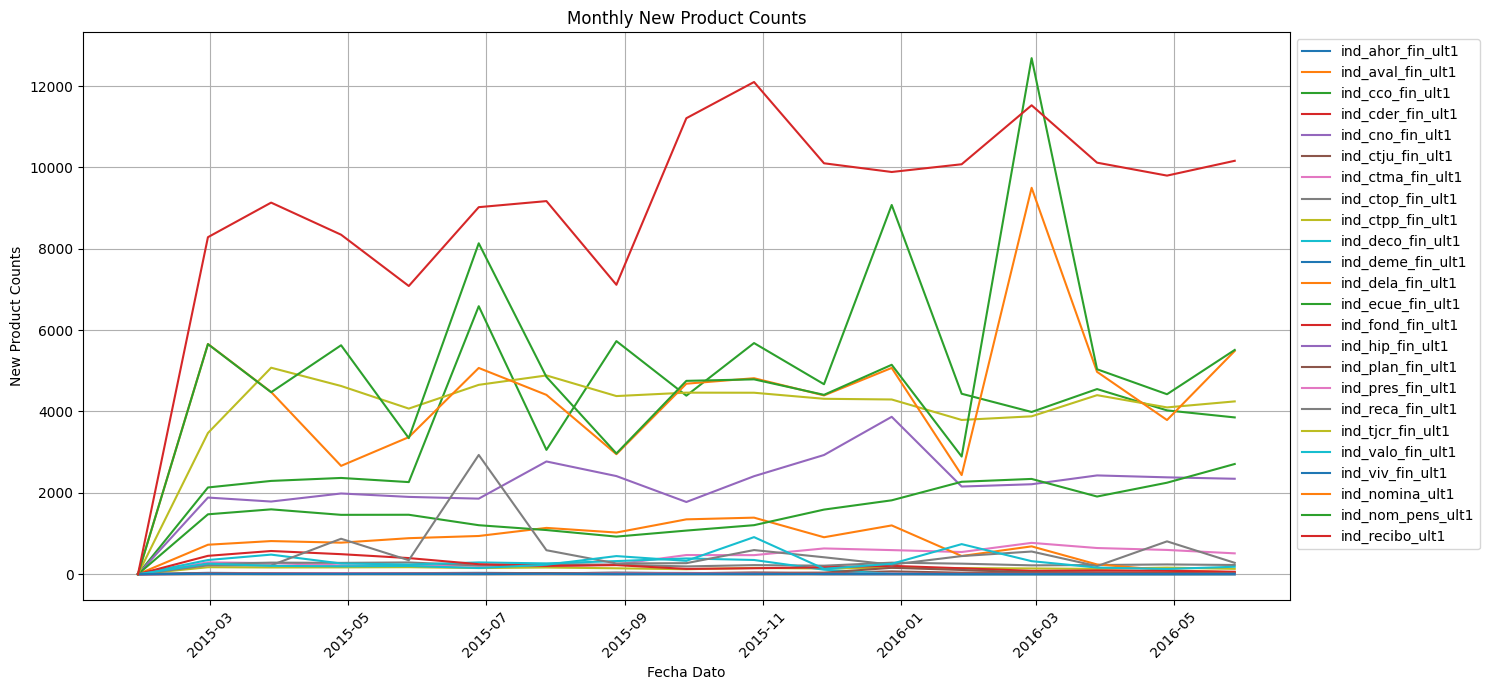

In [5]:
# Convert the Spark DataFrame to a Pandas DataFrame
monthly_new_counts_pd = monthly_new_counts.toPandas()

# Set 'fecha_dato' as index
monthly_new_counts_pd = monthly_new_counts_pd.set_index('fecha_dato')

# Plotting the data
plt.figure(figsize=(15, 7))  # Adjust figure size as needed
for col in monthly_new_counts_pd.columns:
    plt.plot(monthly_new_counts_pd.index, monthly_new_counts_pd[col], label=col)

plt.xlabel('Fecha Dato')
plt.ylabel('New Product Counts')
plt.title('Monthly New Product Counts')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## Thống Kê Số Lượng Khách Hàng Ngừng Sử Dụng Sản Phẩm (Product Churn) Theo Tháng

Đoạn mã này sử dụng Spark để phân tích và thống kê số lượng khách hàng ngừng sử dụng một sản phẩm cụ thể (product churn) theo từng tháng. Nó tập trung vào việc xác định các khách hàng đã chuyển từ sử dụng sản phẩm (giá trị 1) sang không sử dụng sản phẩm (giá trị 0) trong khoảng thời gian 1 tháng.

**Các Bước:**

1.  **Tạo Giá Trị Lag cho Sản Phẩm:**
    *   Với mỗi sản phẩm trong `target_cols`, tạo một cột mới có tên `prev_{col}` chứa giá trị của sản phẩm đó trong tháng trước, sử dụng hàm `F.lag()` và cửa sổ `w` (đã được định nghĩa trước đó, phân vùng theo khách hàng và sắp xếp theo ngày).

2.  **Xác Định Khách Hàng Ngừng Sử Dụng Sản Phẩm:**
    *   Với mỗi sản phẩm, tạo một cột mới có tên `{col}_left`. Cột này nhận giá trị 1 nếu khách hàng:
        *   Đã sử dụng sản phẩm trong tháng trước (`F.col(f"prev_{col}") == 1`).
        *   Không sử dụng sản phẩm trong tháng hiện tại (`F.col(col) == 0`).
        *   Sự thay đổi này xảy ra trong vòng 1 tháng (`F.datediff(F.col("fecha_dato"), F.col("prev_fecha")) < 32`). 

3.  **Tổng Hợp Số Lượng Khách Hàng Ngừng Sử Dụng Sản Phẩm Theo Tháng:**
    *   Nhóm dữ liệu theo `fecha_dato` (ngày tháng, đại diện cho tháng).
    *   Với mỗi sản phẩm, tính tổng số các khách hàng đã ngừng sử dụng sản phẩm đó trong tháng đó (sử dụng `F.sum(f"{col}_left")`).
    *   Đặt tên cho cột kết quả là tên của sản phẩm đó (`alias(col)`).
    *   Sắp xếp kết quả theo ngày tháng (`orderBy("fecha_dato")`).

**Kết Quả:**

Kết quả là một DataFrame có tên `monthly_leave_counts` chứa các thông tin sau:

*   `fecha_dato`: Ngày tháng (đại diện cho tháng).
*   Các cột còn lại: Mỗi cột đại diện cho một sản phẩm trong `target_cols` và chứa số lượng khách hàng đã ngừng sử dụng sản phẩm đó trong tháng đó.

**Chú Thích Thuật Ngữ:**

*   **Product Churn:** Sự ngừng sử dụng một sản phẩm hoặc dịch vụ của khách hàng.
*   **Target Cols:** Danh sách các cột đại diện cho các sản phẩm mục tiêu được phân tích.
*   **Lag:** Giá trị trước đó của một biến. Trong trường hợp này, là giá trị của sản phẩm trong tháng trước.
*   **Leave (Left):** Rời đi, ngừng sử dụng.
*   **Aggregate (Agg):** Gom nhóm dữ liệu và thực hiện một phép toán (trong trường hợp này là tính tổng).


In [6]:
# Create lagged target columns for each product
for col in target_cols:
    df = df.withColumn(f"prev_{col}", F.lag(col).over(w))

# For each target product column, flag rows where the product is dropped:
# (transition from 1 to 0) with days difference < 32.
for col in target_cols:
    df = df.withColumn(f"{col}_left",
            F.when(
            (F.col(f"prev_{col}") == 1) & 
            (F.col(col) == 0) & 
            (F.datediff(F.col("fecha_dato"), F.col("prev_fecha")) < 32),
            1
            ).otherwise(0)
        )

# Aggregate by fecha_dato to obtain the monthly user leave counts for each product
agg_exprs = [F.sum(f"{col}_left").alias(col) for col in target_cols]
monthly_leave_counts = df.groupBy("fecha_dato").agg(*agg_exprs).orderBy("fecha_dato")

df = df.drop("prev_fecha")

for col in target_cols:
    df = df.drop(f"prev_{col}")
    df = df.drop(f"{col}_left")

# monthly_leave_counts.show()

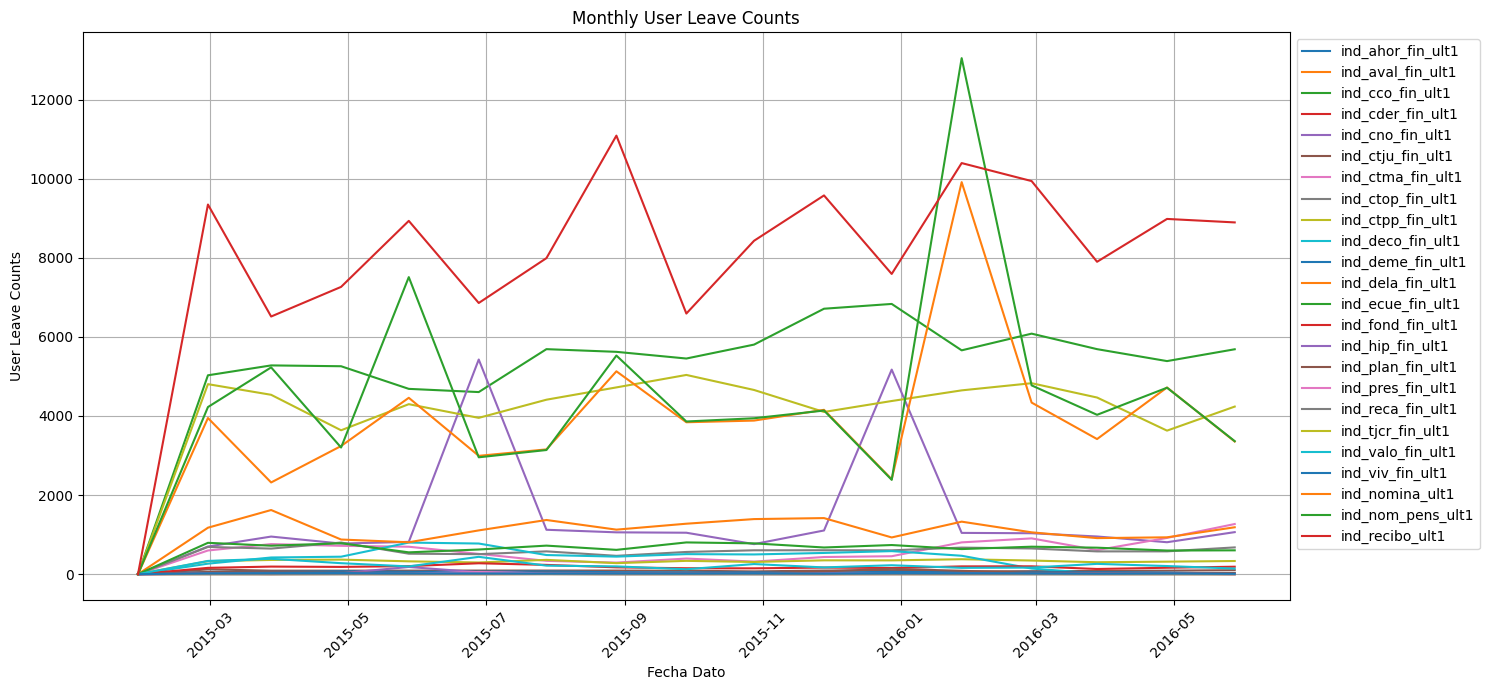

In [7]:
# Convert the Spark DataFrame to a Pandas DataFrame
monthly_leave_counts_pd = monthly_leave_counts.toPandas()

# Set 'fecha_dato' as index
monthly_leave_counts_pd = monthly_leave_counts_pd.set_index('fecha_dato')

# Plotting the data
plt.figure(figsize=(15, 7))  # Adjust figure size as needed
for col in monthly_leave_counts_pd.columns:
    plt.plot(monthly_leave_counts_pd.index, monthly_leave_counts_pd[col], label=col)

plt.xlabel('Fecha Dato')
plt.ylabel('User Leave Counts')
plt.title('Monthly User Leave Counts')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## Thống Kê Số Lượng Bản Ghi và Số Tháng Khách Hàng Xuất Hiện

Đoạn mã này sử dụng Spark để thống kê hai thông tin quan trọng về khách hàng:

1.  **Tổng Số Lượng Bản Ghi (total_count):** Số lượng bản ghi mà mỗi khách hàng (ncodpers) có trong tập dữ liệu. Điều này có thể phản ánh mức độ hoạt động của khách hàng.
2.  **Số Lượng Tháng Riêng Biệt (distinct_month_count):** Số lượng tháng riêng biệt mà mỗi khách hàng xuất hiện trong tập dữ liệu. Giả định là cột `fecha_dato` đại diện cho tháng. Điều này cho biết khách hàng duy trì hoạt động trong bao nhiêu tháng khác nhau.

**Các Bước:**

**1. Tính Tổng Số Lượng Bản Ghi:**

*   `df.groupBy("ncodpers")`: Nhóm các bản ghi theo mã khách hàng (`ncodpers`).
*   `F.count("*")`: Đếm tổng số bản ghi trong mỗi nhóm (mỗi khách hàng).  `"*"` nghĩa là đếm tất cả các cột.
*   `.alias("total_count")`: Đặt tên cho cột kết quả là "total_count".

**2. Tính Số Lượng Tháng Riêng Biệt:**

*   `df.groupBy("ncodpers")`: Nhóm các bản ghi theo mã khách hàng (`ncodpers`).
*   `F.countDistinct("fecha_dato")`: Đếm số lượng giá trị duy nhất trong cột `fecha_dato` (tức là số tháng riêng biệt) cho mỗi khách hàng.
*   `.alias("month_count")`: Đặt tên cho cột kết quả là "month_count".

**Kết Quả:**

*   **`total_counts` DataFrame:** Chứa hai cột:
    *   `ncodpers`: Mã khách hàng.
    *   `total_count`: Tổng số bản ghi của khách hàng đó.
*   **`distinct_month_counts` DataFrame:** Chứa hai cột:
    *   `ncodpers`: Mã khách hàng.
    *   `month_count`: Số lượng tháng riêng biệt mà khách hàng đó xuất hiện.

**Chú Thích Thuật Ngữ:**

*   **ncodpers:** Mã khách hàng.
*   **fecha_dato:** Ngày tháng (giả định đại diện cho tháng).
*   **Aggregate (Agg):** Gom nhóm dữ liệu và thực hiện một phép toán (đếm).
*   **Count Distinct:** Đếm số lượng giá trị duy nhất.


In [8]:
#Count the appearance of customer in one month and count the number of month that customer use product
total_counts = df.groupBy("ncodpers").agg(F.count("*").alias("total_count"))
# total_counts.show()

# Count distinct months a customer appears in (assuming fecha_dato represents the month)
distinct_month_counts = df.groupBy("ncodpers").agg(F.countDistinct("fecha_dato").alias("month_count"))
# distinct_month_counts.show()

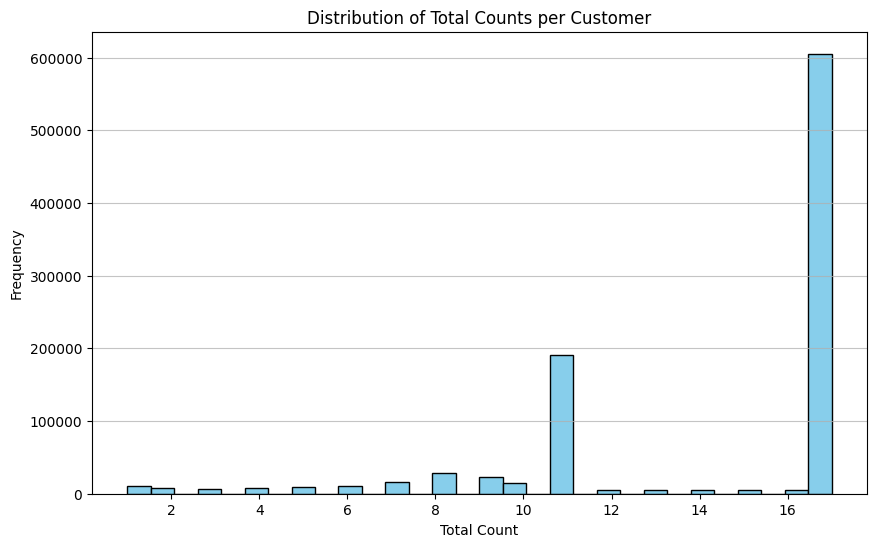

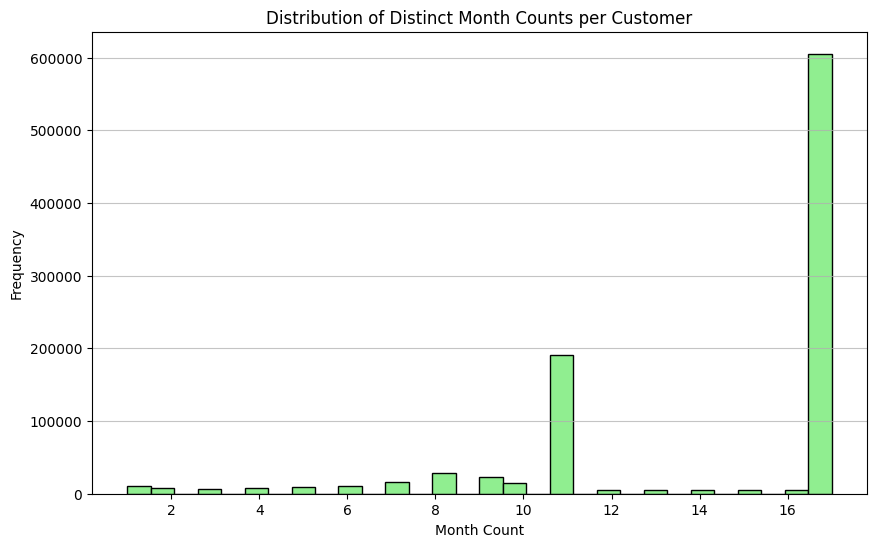

In [9]:
# Convert the Spark DataFrame to a Pandas DataFrame
total_counts_pd = total_counts.toPandas()

# Plotting a histogram of total_counts
plt.figure(figsize=(10, 6))
plt.hist(total_counts_pd['total_count'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Total Count')
plt.ylabel('Frequency')
plt.title('Distribution of Total Counts per Customer')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Convert the Spark DataFrame to a Pandas DataFrame
distinct_month_counts_pd = distinct_month_counts.toPandas()

# Plotting a histogram of distinct_month_counts
plt.figure(figsize=(10, 6))
plt.hist(distinct_month_counts_pd['month_count'], bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Month Count')
plt.ylabel('Frequency')
plt.title('Distribution of Distinct Month Counts per Customer')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Tạo Ma Trận Sự Xuất Hiện Của Khách Hàng Theo Tháng (Customer-Month Matrix)

Đoạn mã tạo một ma trận (customer-month matrix) trong Spark, trong đó mỗi hàng đại diện cho một khách hàng (ncodpers) và mỗi cột đại diện cho một tháng (fecha_dato). Giá trị trong ma trận là 1 nếu khách hàng xuất hiện trong tháng đó, và 0 nếu không.

**Các Bước:**

1.  **Chọn Dữ Liệu và Loại Bỏ Trùng Lặp:**
    *   Chọn hai cột "ncodpers" (mã khách hàng) và "fecha_dato" (ngày tháng).
    *   Loại bỏ các bản ghi trùng lặp (distinct()). Điều này giữ lại chỉ một bản ghi cho mỗi khách hàng trong mỗi tháng.

2.  **Tạo Ma Trận Sử Dụng Pivot:**
    *   Sử dụng hàm `groupBy("ncodpers")` để nhóm dữ liệu theo mã khách hàng.
    *   Sử dụng hàm `pivot("fecha_dato")` để chuyển đổi các giá trị duy nhất trong cột "fecha_dato" thành các cột mới. Mỗi cột mới đại diện cho một tháng duy nhất.
    *   Sử dụng hàm `agg(F.lit(1))` để đặt giá trị trong mỗi ô của ma trận là 1. Nếu một khách hàng xuất hiện trong một tháng cụ thể, ô tương ứng sẽ có giá trị là 1.

3.  **Điền Giá Trị Thiếu Bằng 0:**
    *   Sử dụng hàm `fillna(0)` để điền tất cả các giá trị thiếu (NULL) trong ma trận bằng 0. Điều này đảm bảo rằng nếu một khách hàng không xuất hiện trong một tháng nào đó, ô tương ứng sẽ có giá trị là 0.

**Kết Quả:**

Kết quả là một DataFrame đại diện cho ma trận customer-month. Cột đầu tiên là "ncodpers" (mã khách hàng). Các cột còn lại đại diện cho các tháng khác nhau (fecha_dato). Giá trị trong ma trận cho biết liệu khách hàng có xuất hiện trong tháng đó hay không (1 = có, 0 = không).

**Chú Thích Thuật Ngữ:**

*   **ncodpers:** Mã khách hàng.
*   **fecha_dato:** Ngày tháng.
*   **Distinct:** Loại bỏ các bản ghi trùng lặp.
*   **Pivot:** Chuyển đổi các giá trị duy nhất trong một cột thành các cột mới.
*   **Aggregate (Agg):** Gom nhóm dữ liệu và thực hiện một phép toán.
*   **Literal (Lit):** Tạo một giá trị không đổi.
*   **Fill NA (fillna):** Điền các giá trị thiếu (NULL) bằng một giá trị cụ thể.

In [10]:
customer_month = df.select("ncodpers", "fecha_dato").distinct()

customer_appear_month = customer_month.groupBy("ncodpers") \
    .pivot("fecha_dato") \
    .agg(F.lit(1)) \
    .fillna(0)

## Xác Định Lần Xuất Hiện Đầu Tiên của Khách Hàng (ncodpers)

Đoạn mã xác định ngày xuất hiện đầu tiên (fecha_dato) của mỗi khách hàng (ncodpers) trong một tập dữ liệu, sử dụng Spark.

**Các Bước:**

1.  **Nhóm Dữ Liệu Theo Khách Hàng:** Sử dụng `groupBy("ncodpers")` để nhóm tất cả các bản ghi theo mã khách hàng.

2.  **Tìm Ngày Xuất Hiện Đầu Tiên:** Sử dụng hàm `F.min("fecha_dato")` trong hàm `agg()` để tìm ngày nhỏ nhất (tức là ngày sớm nhất) trong nhóm các bản ghi của mỗi khách hàng.  Hàm này trả về ngày xuất hiện đầu tiên của khách hàng.

**Kết Quả:**

Kết quả là một DataFrame chứa hai cột:

*   "ncodpers": Mã khách hàng.
*   "min(fecha_dato)": Ngày xuất hiện đầu tiên của khách hàng đó trong dữ liệu.

**Chú Thích Thuật Ngữ:**

*   **ncodpers:** Mã khách hàng (có thể là viết tắt của "número de cliente persona").
*   **fecha_dato:** Ngày dữ liệu được thu thập hoặc ngày liên quan đến bản ghi.
*   **Aggregate (Agg):** Gom nhóm dữ liệu và thực hiện một phép toán (trong trường hợp này là tìm giá trị nhỏ nhất).


In [11]:
first_appearance = df.groupBy("ncodpers").agg(F.min("fecha_dato"))

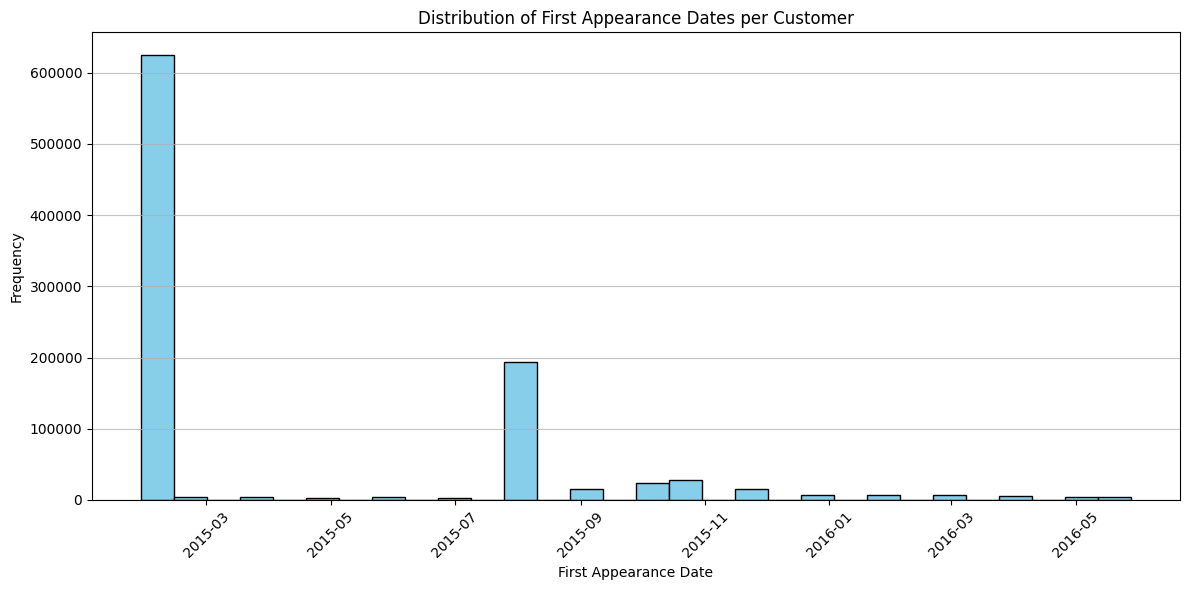

In [12]:
# Convert the Spark DataFrame to a Pandas DataFrame
first_appearance_pd = first_appearance.toPandas()

# Plotting a histogram of first appearance dates
plt.figure(figsize=(12, 6))
plt.hist(first_appearance_pd['min(fecha_dato)'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('First Appearance Date')
plt.ylabel('Frequency')
plt.title('Distribution of First Appearance Dates per Customer')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Tính Toán Mức Thu Nhập Trung Bình (Renta) Theo Tỉnh (Nomprov)

Đoạn mã tính toán mức thu nhập trung bình (Renta) theo từng tỉnh (Nomprov) từ một tập dữ liệu sử dụng Spark.

**Các Bước:**

1.  **Chọn và Lọc Dữ Liệu:**
    *   Chọn hai cột "nomprov" (tên tỉnh) và "renta" (thu nhập).
    *   Loại bỏ các bản ghi trùng lặp (distinct())
    *   Lọc bỏ các bản ghi có giá trị "nomprov" là NULL (F.col("nomprov").isNotNull()). Điều này đảm bảo tính chính xác của kết quả bằng cách loại trừ các bản ghi không có thông tin về tỉnh.

2.  **Tính Trung Bình Thu Nhập theo Tỉnh:**
    *   Nhóm dữ liệu theo cột "nomprov" (groupBy("nomprov")).
    *   Sử dụng hàm `F.avg("renta")` để tính trung bình thu nhập cho mỗi tỉnh.
    *   Sử dụng hàm `F.round(..., 2)` để làm tròn kết quả trung bình thu nhập đến hai chữ số thập phân.
    *   Đổi tên cột kết quả thành "avg_renta" (alias("avg_renta")).

**Kết Quả:**

Kết quả là một DataFrame chứa hai cột:

*   "nomprov": Tên của tỉnh.
*   "avg_renta": Mức thu nhập trung bình của tỉnh đó (đã làm tròn đến hai chữ số thập phân).

**Chú Thích Thuật Ngữ:**

*   **Renta:** Thu nhập.
*   **Nomprov:** Tên tỉnh (viết tắt của "nombre provincia").
*   **Distinct:** Loại bỏ các bản ghi trùng lặp.
*   **Aggregate (Agg):** Gom nhóm dữ liệu và thực hiện một phép toán (ví dụ: tính trung bình).
*   **Alias:** Đổi tên cột.


In [13]:
avg_renta = df.select("nomprov","renta").distinct().filter(F.col("nomprov").isNotNull())
avg_renta = avg_renta.groupBy("nomprov").agg(F.round(F.avg("renta"),2).alias("avg_renta"))

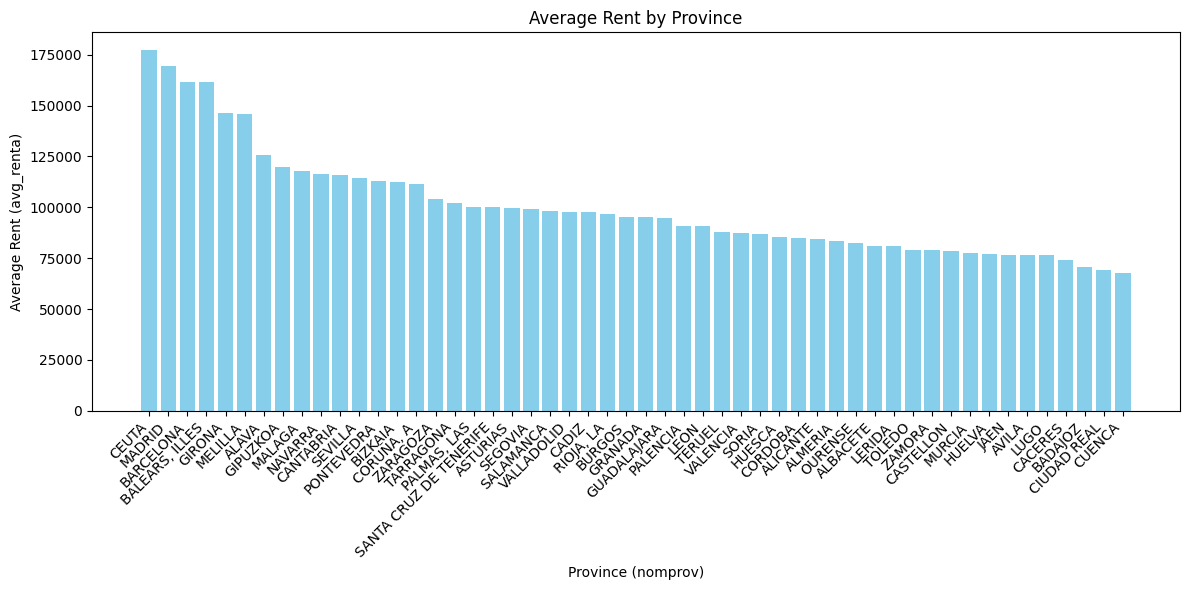

In [14]:
# Convert the Spark DataFrame to a Pandas DataFrame
avg_renta_pd = avg_renta.toPandas()

avg_renta_pd = avg_renta_pd.sort_values(by='avg_renta', ascending=False)

# Plotting a bar chart of average rent by province
plt.figure(figsize=(12, 6))
plt.bar(avg_renta_pd['nomprov'], avg_renta_pd['avg_renta'], color='skyblue')
plt.xlabel('Province (nomprov)')
plt.ylabel('Average Rent (avg_renta)')
plt.title('Average Rent by Province')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Phân Tích Phát Sinh Sản Phẩm Mới (Positive Flank)

Đoạn mã phân tích sự phát sinh (Positive Flank) của các sản phẩm mới (Target Products) trong dữ liệu khách hàng. Mục tiêu: Xác định thời điểm khách hàng bắt đầu sử dụng sản phẩm (từ 0 lên 1).

**Các Bước:**

1.  Chuẩn Bị Dữ Liệu: Chuyển đổi ngày, tạo cột Lag cho sản phẩm và ngày.
2.  Xác Định Positive Flank: Tìm các sự kiện từ "không dùng" sang "dùng" sản phẩm trong < 32 ngày.
3.  Phân Tích & Trực Quan:
    *   Biểu đồ 1 - 24: Tỷ lệ tương đối hàng tháng. Highlight tháng 5.
    *   Biểu đồ 25: Tổng số Positive Flank trong chu kì được xét.
    *   Biểu đồ 26: Tỷ lệ tháng 5 so với 3 tháng trước. (Tháng 5 tăng trưởng so với quá khứ)
    *   Biểu đồ 27: Tần suất sản phẩm trong tháng 5. (Sản phẩm nào được dùng nhiều trong tháng 5)

**Điểm Nhấn: Tháng 5 (Dự Đoán Nhu Cầu Năm Sau)**

Phân tích các biểu đồ liên quan đến tháng 5 để dự đoán xu hướng sử dụng sản phẩm, từ đó đưa ra chiến lược để dự đoán cho năm sau.

**Chú Thích Thuật Ngữ:**

*   **Positive Flank:** Sự kiện khi một khách hàng chuyển từ không sử dụng sản phẩm sang sử dụng sản phẩm.
*   **Target Products:** Các sản phẩm mục tiêu được phân tích.
*   **Lag:** Giá trị trước đó của một biến (ví dụ: giá trị sản phẩm tháng trước).
*   **Highlight:** Làm nổi bật, nhấn mạnh.


In [15]:
# Ensure fecha_dato is in date format
df = df.withColumn("fecha_dato", F.to_date("fecha_dato", "yyyy-MM-dd"))

# Define target product columns (all columns from index 24 onward)
targetCols = [c for c in df.columns[24:] if not c.startswith("lag_")]
nbTargetCols = len(targetCols)

# Get sorted unique dates (skip the first one as in the R code)
sorted_dates = [r.fecha_dato for r in df.select("fecha_dato").distinct().orderBy("fecha_dato").collect()][1:]
nbDates = len(sorted_dates)

# Create a window partitioned by client (ncodpers) ordered by fecha_dato
w = Window.partitionBy("ncodpers").orderBy("fecha_dato")

# Add lag columns: lag_fecha and for each product the lag value
df = df.withColumn("lag_fecha", F.lag("fecha_dato").over(w))
for t in targetCols:
    df = df.withColumn(f"lag_{t}", F.lag(F.col(t)).over(w))

# For each product, flag positive flank occurrences:
# Condition: for a given product, previous value equals 0 and current equals 1,
# and the difference in fecha_dato is less than 32 days.
all_counts = {}
for t in targetCols:
    pos_cond = (F.col(t) == 1) & (F.col(f"lag_{t}") == 0) & (F.datediff(F.col("fecha_dato"), F.col("lag_fecha")) < 32)
    df_flag = df.withColumn("positive_flank", F.when(pos_cond, 1).otherwise(0))
    
    # Group by fecha_dato and count positive flanks for this product
    prod_counts = df_flag.groupBy("fecha_dato").agg(F.sum("positive_flank").alias("count"))
    # Convert to Pandas, ensure the index covers all sorted_dates (missing dates -> 0)
    prod_pd = prod_counts.toPandas()
    prod_pd['fecha_dato'] = pd.to_datetime(prod_pd['fecha_dato'])
    prod_pd = prod_pd.set_index('fecha_dato').reindex(sorted_dates, fill_value=0)
    all_counts[t] = prod_pd['count']

df = df.drop("lag_fecha")
for t in targetCols:
    df = df.drop(f"lag_{t}")

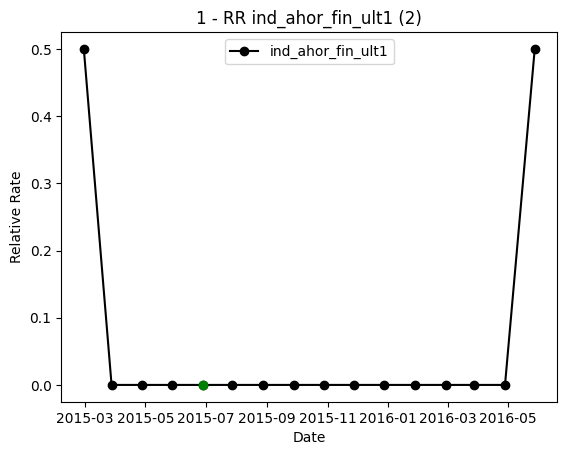

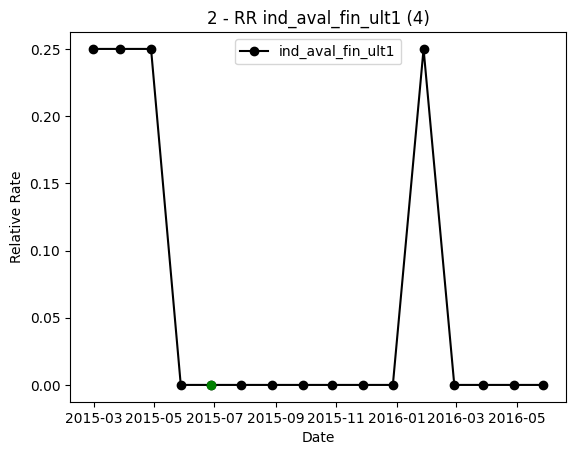

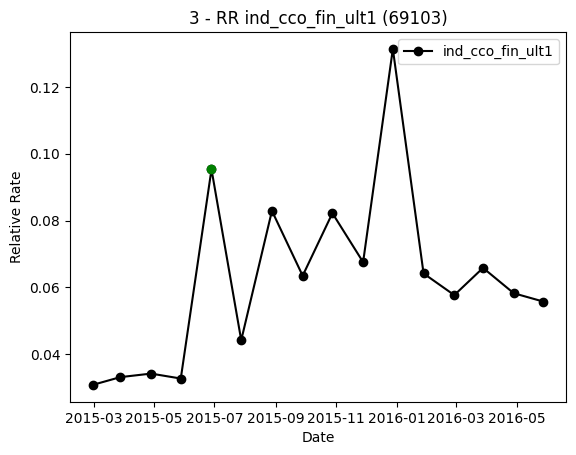

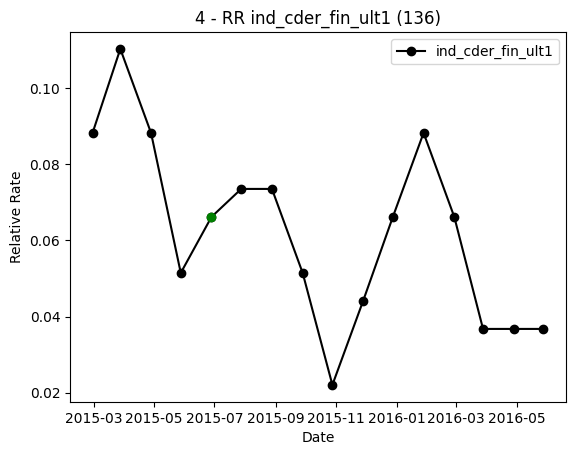

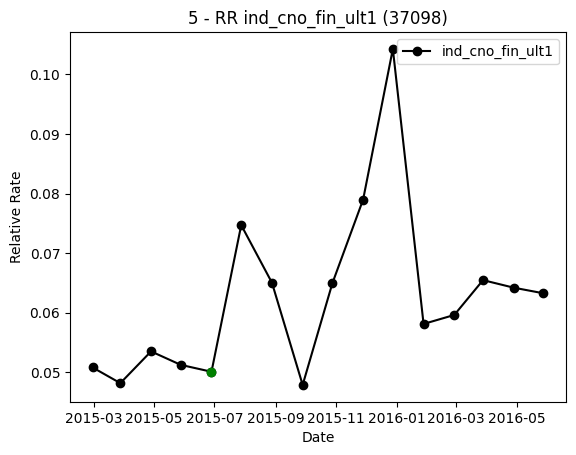

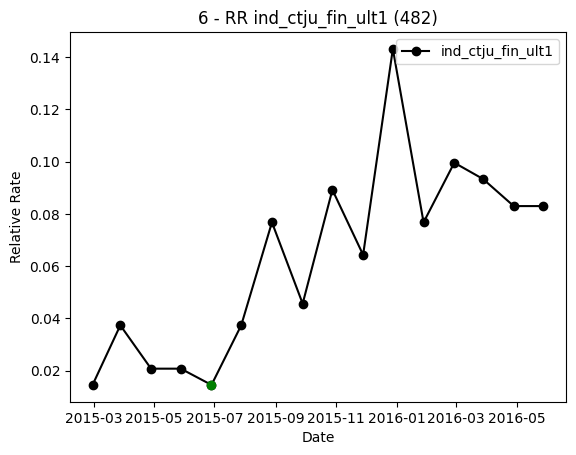

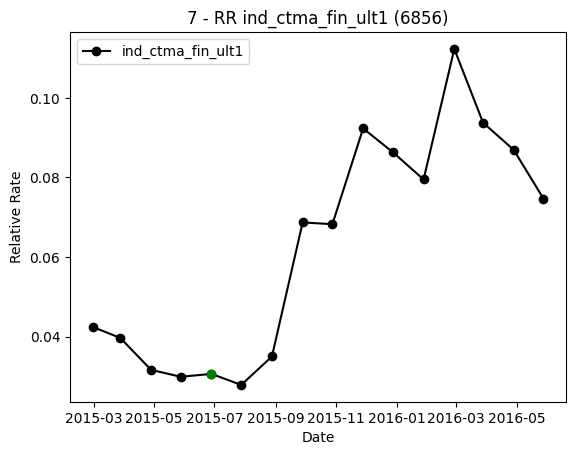

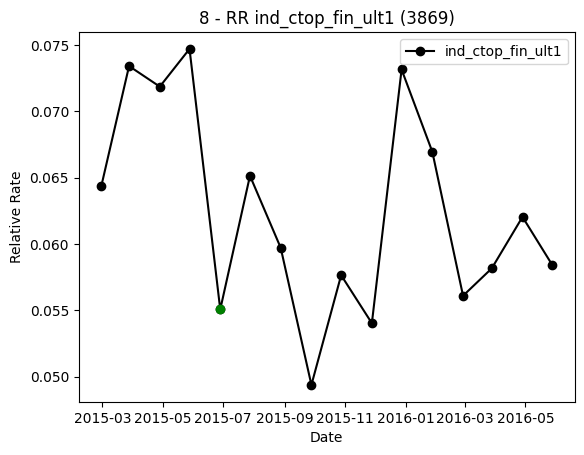

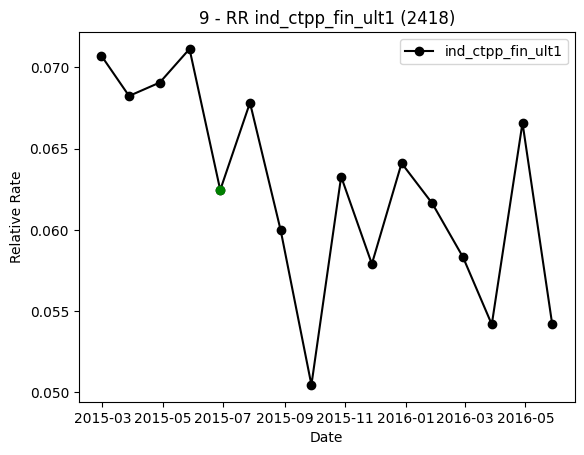

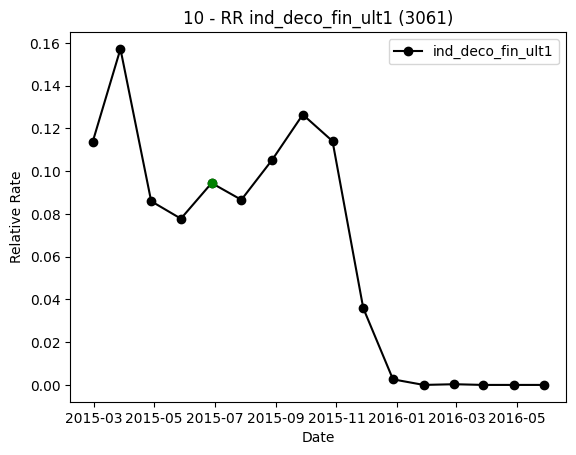

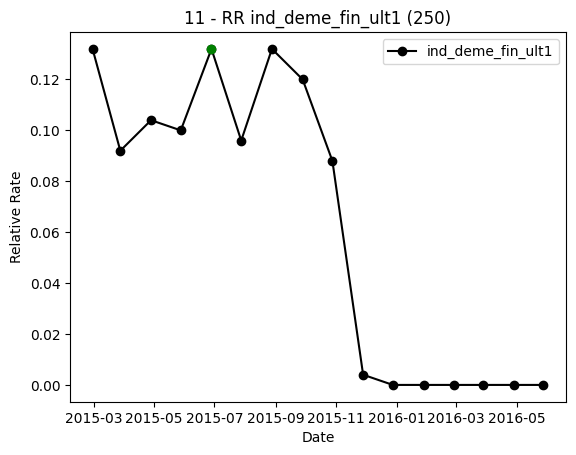

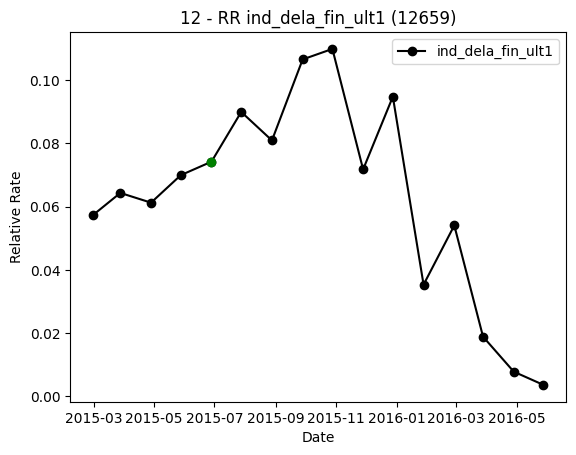

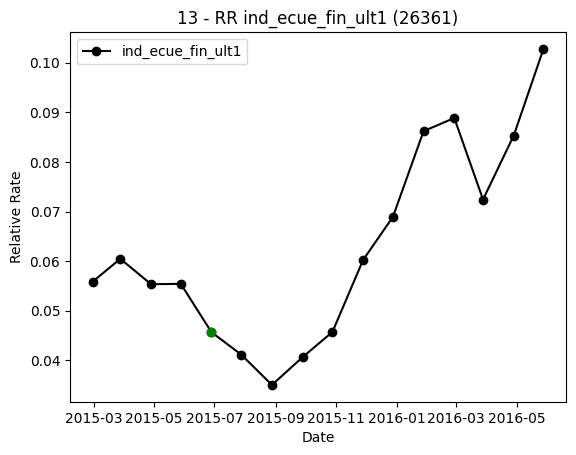

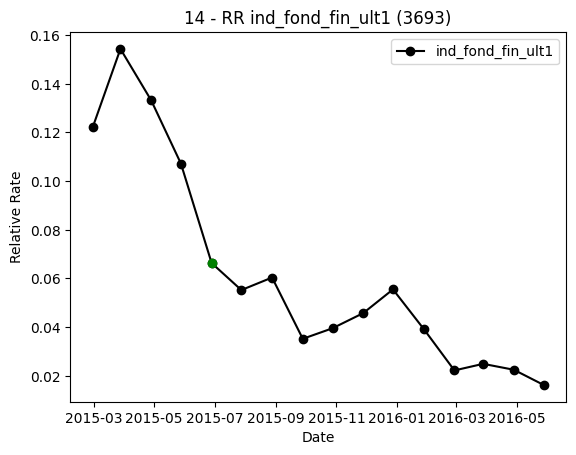

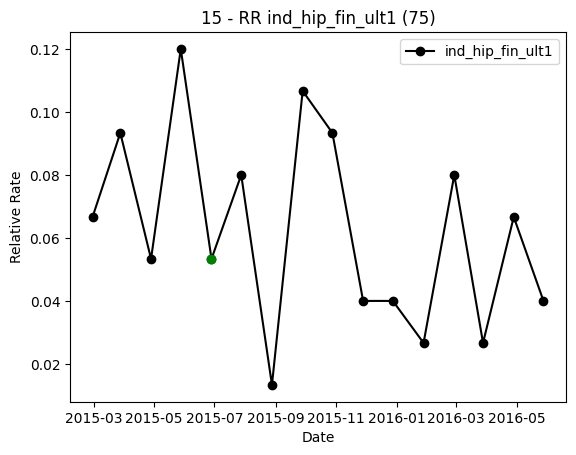

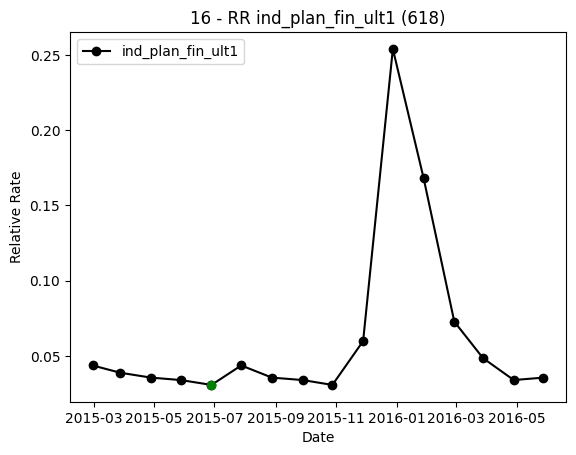

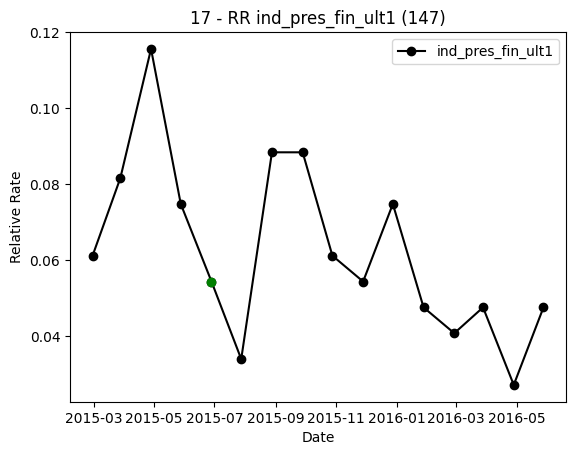

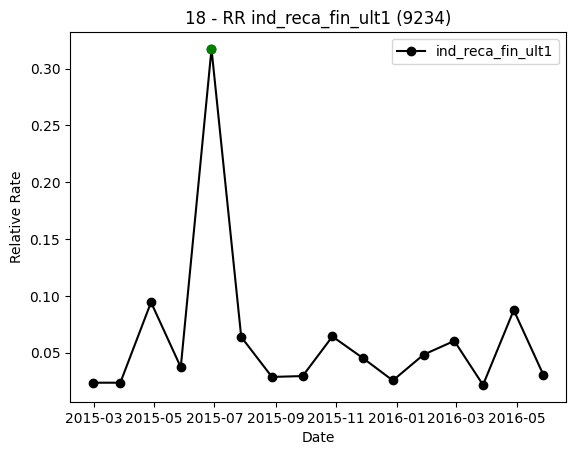

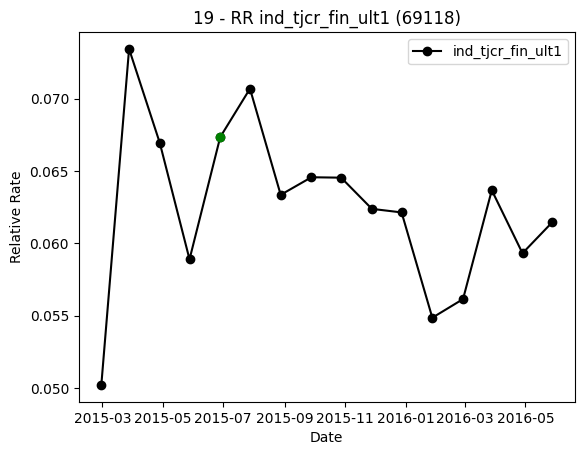

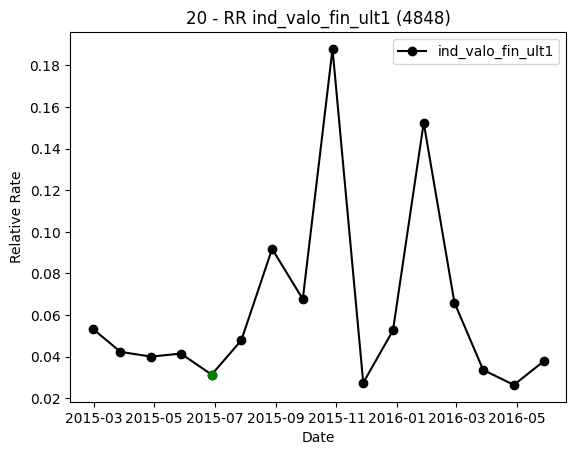

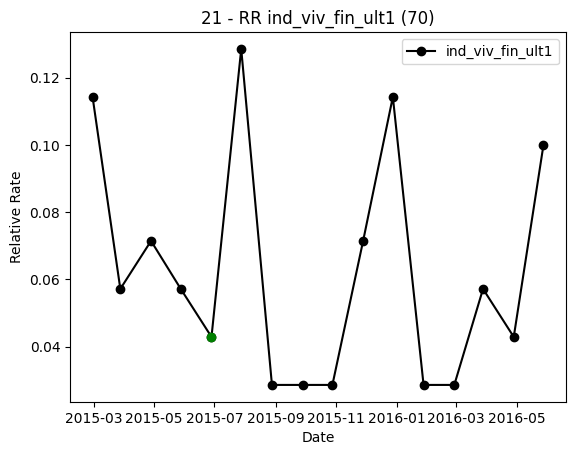

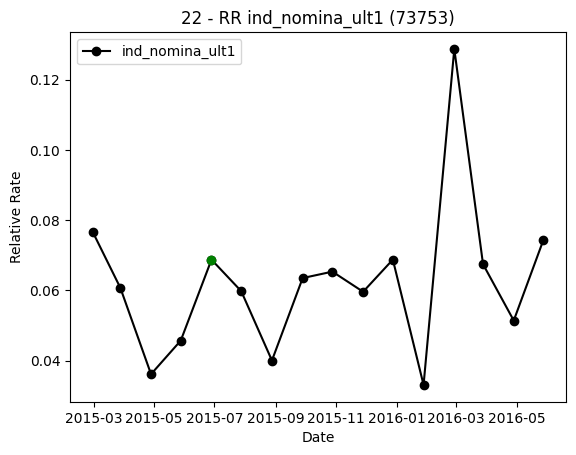

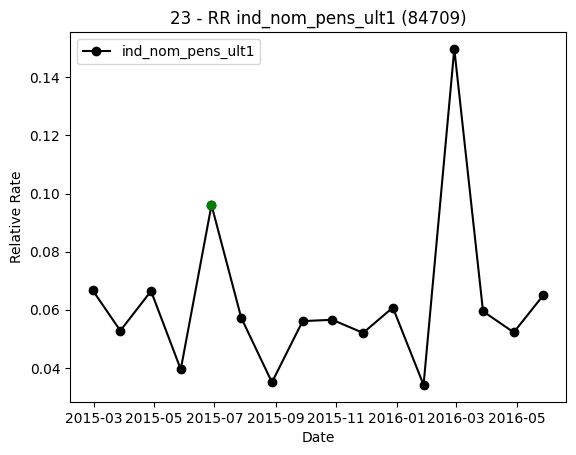

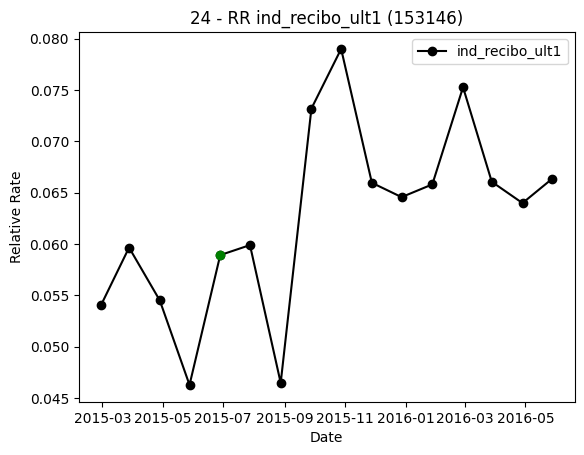

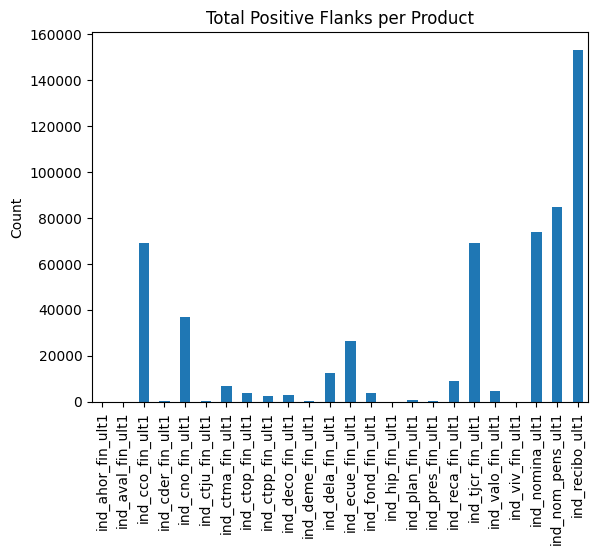

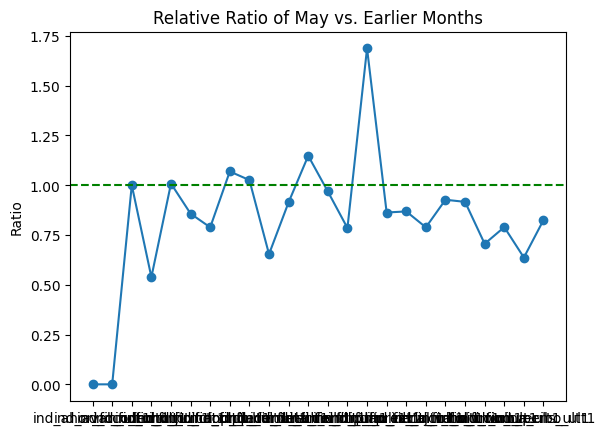

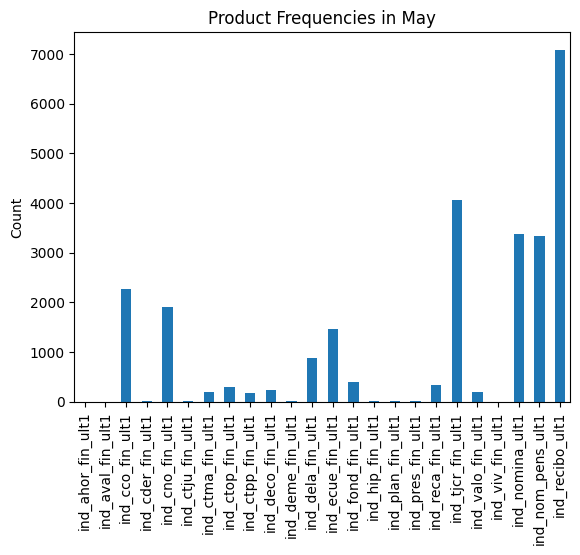

In [16]:
# Combine all product counts into a DataFrame (rows: months, columns: products)
allCounts_pdf = pd.DataFrame(all_counts, index=sorted_dates)

# ----- Plot relative monthly fractions for each product -----
for i, t in enumerate(targetCols):
    counts = allCounts_pdf[t]
    frac = counts / counts.sum() if counts.sum() != 0 else counts
    plt.figure()
    plt.plot(sorted_dates, frac, marker='o', color='black', label=t)
    if len(sorted_dates) >= 5:
        plt.plot(sorted_dates[4], frac.iloc[4], marker='o', color='green')
    plt.title(f"{i+1} - RR {t} ({counts.sum()})")
    plt.xlabel("Date")
    plt.ylabel("Relative Rate")
    plt.legend()
    plt.show()
    plt.pause(2)

# ----- Overall Influence: Compute row-wise fractions -----
row_sums = allCounts_pdf.sum(axis=1)
overall_frac = allCounts_pdf.divide(row_sums, axis=0)

# ----- Relative Ratios Calculation -----
# For May (4th row: index 3) vs. first three months (rows 0 to 2)
if allCounts_pdf.shape[0] >= 4:
    relativeRatiosMay = allCounts_pdf.iloc[3] / allCounts_pdf.iloc[:3].mean(axis=0)
else:
    relativeRatiosMay = pd.Series(0, index=targetCols)

# ----- Plotting -----
# Total positive flanks per product
nbPosFlanks = allCounts_pdf.sum(axis=0)
plt.figure()
nbPosFlanks.plot(kind="bar")
plt.title("Total Positive Flanks per Product")
plt.ylabel("Count")
plt.show()

# Relative ratio of May versus earlier months
plt.figure()
plt.plot(relativeRatiosMay, marker='o')
plt.axhline(y=1, color="green", linestyle="--")
plt.title("Relative Ratio of May vs. Earlier Months")
plt.ylabel("Ratio")
plt.show()

# Product frequencies in May (5th month)
if allCounts_pdf.shape[0] >= 4:
    mayCount = allCounts_pdf.iloc[3]
    plt.figure()
    mayCount.plot(kind="bar")
    plt.title("Product Frequencies in May")
    plt.ylabel("Count")
    plt.show()

## Phân Tích Ảnh Hưởng của Tính Năng (Feature Impact) Đến MAP

Đoạn mã phân tích ảnh hưởng của các sản phẩm (tính năng) mới được khách hàng sử dụng đến một chỉ số (MAP - Mean Average Precision - có thể hiểu là độ chính xác trung bình). Mã tập trung vào việc xác định mức độ đóng góp của từng sản phẩm mới được chấp nhận đối với tổng số sản phẩm mới được khách hàng sử dụng trong mỗi tháng.

**Các Bước:**

1.  **Chuẩn Bị Dữ Liệu:**
    *   Đọc dữ liệu.
    *   Chuyển đổi cột ngày và tính giá trị tháng số.
    *   Xác định các cột sản phẩm (tính năng).

2.  **Tính Toán Sự Chấp Nhận Sản Phẩm Mới:**
    *   Sử dụng cửa sổ (Window) để tính giá trị Lag của từng sản phẩm.
    *   Xác định sự chấp nhận sản phẩm mới (New Adoption) khi giá trị hiện tại trừ giá trị Lag bằng 1.

3.  **Tính Tỷ Lệ Đóng Góp:**
    *   Tính tổng số sản phẩm mới được khách hàng chấp nhận (User New Count) cho mỗi hàng.
    *   Tính tỷ lệ đóng góp (Ratio) của từng sản phẩm mới được chấp nhận so với tổng số sản phẩm mới được chấp nhận bởi khách hàng đó.

4.  **Tổng Hợp Theo Tháng:**
    *   Nhóm dữ liệu theo tháng (Fecha Dato) và tính trung bình tỷ lệ đóng góp của từng sản phẩm.

5.  **Tính Ảnh Hưởng Tổng Thể:**
    *   Tính trung bình đóng góp hàng tháng của từng sản phẩm để xác định ảnh hưởng tổng thể của tính năng (Feature Impact) đến MAP.

**Kết Quả:**

Đoạn mã in ra ảnh hưởng trung bình của từng tính năng (sản phẩm) đến MAP. Các giá trị lớn hơn biểu thị các sản phẩm có ảnh hưởng lớn hơn đến chỉ số MAP.

**Chú Thích Thuật Ngữ:**

*   **Feature Impact:** Ảnh hưởng của một tính năng đến một chỉ số quan trọng.
*   **MAP (Mean Average Precision):** Độ chính xác trung bình (một chỉ số đánh giá hiệu quả).
*   **Target Products:** Các sản phẩm mục tiêu được phân tích.
*   **Lag:** Giá trị trước đó của một biến (ví dụ: giá trị sản phẩm tháng trước).
*   **New Adoption:** Sự chấp nhận sản phẩm mới (khách hàng bắt đầu sử dụng sản phẩm).
*   **Ratio:** Tỷ lệ, so sánh một giá trị với một giá trị khác.


In [17]:
# Assume that product indicator columns start from column index 24 onward
all_cols = df.columns
productCols = all_cols[24:]  # adjust if needed

# Convert date column and calculate a numerical month (year*12 + month)
df = df.withColumn("fecha_dato", F.to_date("fecha_dato", "yyyy-MM-dd"))
df = df.withColumn("month_value", F.expr("year(fecha_dato)*12 + month(fecha_dato)"))

# Create a window partitioned by customer and ordered by fecha_dato
w = Window.partitionBy("ncodpers").orderBy("fecha_dato")

# For each product column, compute the lagged value and then a new-adoption indicator: 1 if current minus lag equals 1, else 0.
for col in productCols:
    df = df.withColumn(f"lag_{col}", F.lag(F.col(col)).over(w)) \
           .withColumn(f"new_{col}", F.when(F.col(col) - F.col(f"lag_{col}") == 1, 1).otherwise(0))

# Compute, per row, the total number of new product adoptions
newIndicators = [F.col(f"new_{col}") for col in productCols]
df = df.withColumn("user_new_count", sum(newIndicators))

# We skip the first record per customer (where lag is null) and consider rows with at least one new product
df_filtered = df.filter(F.col("user_new_count") > 0)

# For each product, compute the per-row contribution as new_indicator/user_new_count
for col in productCols:
    df_filtered = df_filtered.withColumn(f"ratio_{col}", F.col(f"new_{col}")/F.col("user_new_count"))

# Now group by the current month (we use the fecha_dato as proxy) to aggregate the relative contribution per product.
agg_exprs = [F.avg(f"ratio_{col}").alias(col) for col in productCols]
month_contrib = df_filtered.groupBy("fecha_dato").agg(*agg_exprs).orderBy("fecha_dato")

# # Optionally, display the monthly contributions
# month_contrib.show(10, truncate=False)

# To summarize the MAP impact per feature over time, average the monthly contributions
feature_impact = month_contrib.agg(*[F.avg(col).alias(col) for col in productCols]).collect()[0].asDict()

# print("Feature impact to MAP (average relative contribution):")
# for feature, impact in feature_impact.items():
#     print(f"Feature: {feature}, Impact: {impact}")

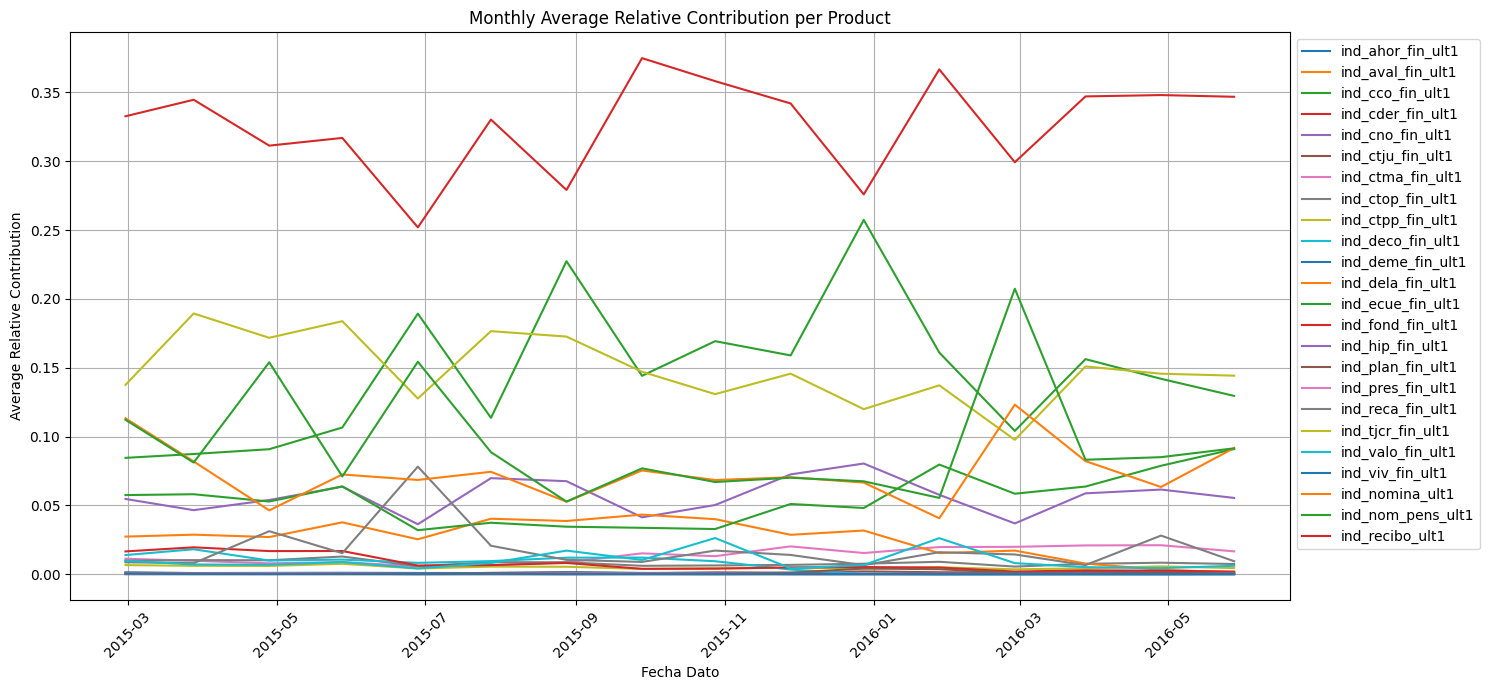

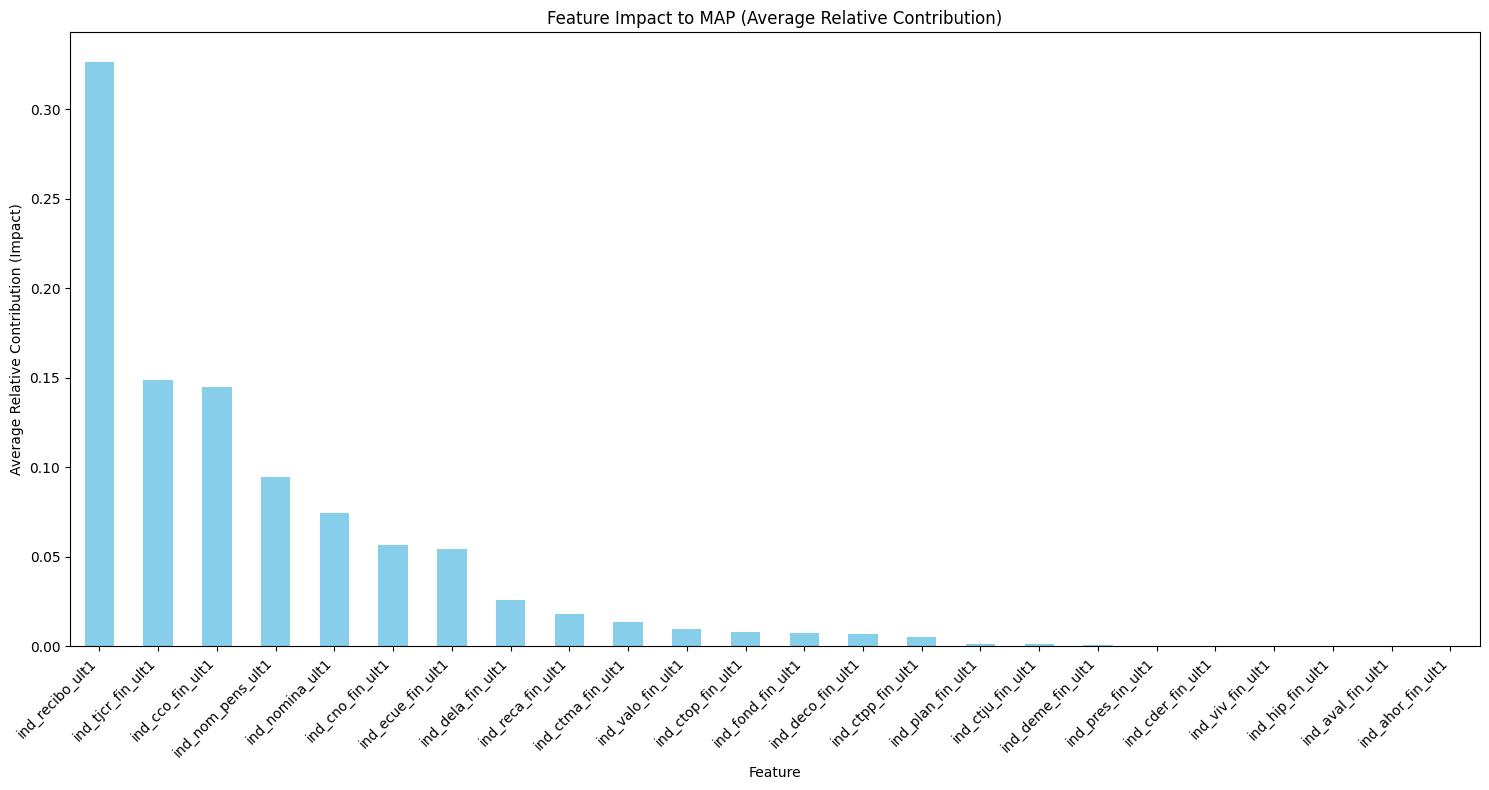

In [18]:
# Convert the Spark DataFrame to a Pandas DataFrame
month_contrib_pd = month_contrib.toPandas()

# Set 'fecha_dato' as index
month_contrib_pd = month_contrib_pd.set_index('fecha_dato')

# Plotting the data
plt.figure(figsize=(15, 7))  # Adjust figure size as needed
for col in month_contrib_pd.columns:
    plt.plot(month_contrib_pd.index, month_contrib_pd[col], label=col)

plt.xlabel('Fecha Dato')
plt.ylabel('Average Relative Contribution')
plt.title('Monthly Average Relative Contribution per Product')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Convert the feature_impact dictionary to a Pandas Series
feature_impact_series = pd.Series(feature_impact)

# Sort the series by impact values
feature_impact_series = feature_impact_series.sort_values(ascending=False)

# Plotting a bar chart of feature impacts
plt.figure(figsize=(15, 8))
feature_impact_series.plot(kind='bar', color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Average Relative Contribution (Impact)')
plt.title('Feature Impact to MAP (Average Relative Contribution)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
spark.stop()